<center>

# Trabajo Práctico Final
## Procesamiento de Imágenes Biomédicas
### Primer Cuatrimestre 2024


### _Diseño de un algoritmo automatizado para la detección de epilepsia en tiempo real mediante EEG_


<table>
  <tr>
    <th>Docentes</th>
    <th>Alumnos</th>
  </tr>
  <tr>
    <td>
      - Roberto Sebastián Tomás<br>
      - Aylin Agatha Vazquez Chenlo<br>
      - Francisco Tassara<br>
      - Victoria Reppucci
    </td>
    <td>
      - Bajlec, Ivo - 62175<br>
      - Grau, Gonzalo Andrés - 62259<br>
      - Neira, Lucas Matias - 61570
    </td>
  </tr>
</table>



</center>



## Estado del arte

## Problemática

Los ataques epilépticos se caracterizan por presentar una desicronización de los ritmos cerebrales, afectando el desarrollo normal de aquellos que padecen de la patología. Si bien los síntomas de estos ataques tienen muchas variantes, en general las personas con epilepsia sufren de convulsiones, rigidez muscular, pérdida del conocimiento y confusión temporal. 

Estos ataques ocurren de manera espontánea, por lo que son difíciles de predecir con exactitud. El estudio de la epilepsia a partir de la señal de EEG es vital para poder predecir el momento de inicio de estos ataques, previniendo al paciente o profesionales de la salud, evitando futuros inconvenientes y posibles problemas de salud causados indirectamente por el ataque epiléptico.

## Objetivo y diseño

El objetivo de este trabajo es diseñar e implementar un algoritmo para la detección de ataques epilépticos mediante el procesamiento _online_ de señales de EGG. Para ello, se preacondicionaran las lecturas de segmentos breves de un conjunto seleccionado de canales, para luego extraer sus características y posteriormente clasificarlas acordemente. 

## Desarrollo

### Base de datos

Las señales utilizadas en el código provienen de la base de datos provista por [ref]. En particular, se trabajarán con seis archivos `.edf`:

- PN01-1
- PN05-2
- PN05-3
- PN05-4
- PN09-1
- PN09-2
- PN09-3
- PN12-1.2
- PN12-4
- PN13-1
- PN13-2
- PN13-3
- PN16-1
- PN16-2

Estos archivos `.edf` contienen distintos registros de EEG para los pacientes, PN01, PN05, PN08, PN12, PN13 y PN16. Se seleccionaro estos pacientes para entrenar los modelos de Machine Learning, ya que estos pacientes comparten la característica de presentar el mismo tipo de ataque epiléptico: sus ataques epilépticos nacen en lóbulo temporal del lazo izquierdo del encéfalo.

La base de datos puede ser accedida a través del siguiente link:

* BASE DE DATOS: [Siena Scalp EEG Database](https://physionet.org/content/siena-scalp-eeg/1.0.0/#files-panel)

### Librerías

El desarrolló del código hará uso de las siguientes librerías:

- numpy
- pandas
- matplotlib
- seaborn
- scipy
- mne
- slkearn
- os
- pickle

Por otro lado, se utilizarán los siguientes archivos `.py`:

- FVfunctions.py
- dataset_reader.py
- online_signal_test.py

Estos últimos archivos contienen métodos desarrollados especialmente para un funcionamiento adecuado del código sin exceso de recursos computacionales, y, además, para auemntar la legibilidad del presente documento.


In [16]:
# Importación de librerías

import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from typing import List, Dict, Tuple
from datetime import  datetime, timedelta
from mne import io
from scipy import signal

# propias
from FVfunctions import getMeData, getMeFeatures, pot4signals, BANDAS
from features_stats import stats_features
from dataset_reader import get_seizure_events, get_seizure_array
from online_signal_test import online_signal_test

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn import model_selection as ms
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


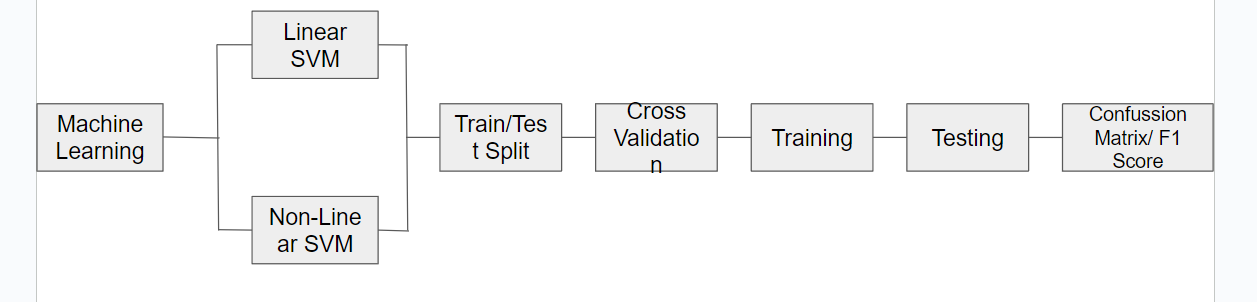

### Técnicas de acondicionmiento de señales biomédicas

Para acondicionar las señales, se les aplicó un filtro pasabandas FIR seguido un rechazabandas IIR.

In [10]:
def FIRfilterBP(arr_signals: np.ndarray,
                freq:List[int] | None = None,
                order: int=(2 ** 8) + 1,
                fs: int=512) -> np.ndarray:
    """
    Aplica un filtro pasabandas FIR vectorialmente a un array de señales
    :param arr_signals: matriz NxL, donde cada fila es una señal, cada columna una muestra temporal
    :param freq: lista de frecuencias de corte
    :param order: orden del filtro
    :param fs: frecuencia de muestreo
    :return: matrix NxL con las señales filtradas
    """
    if freq is None:
        freq = [1, 100]

    b_bp = signal.firwin(numtaps=order, cutoff=freq, window="blackman", pass_zero="bandpass", fs=fs)
    arr_filtered_signals = signal.filtfilt(b_bp, 1, arr_signals, axis=1)

    return arr_filtered_signals


def IIRfilterBS(arr_signals: np.ndarray,
                freq: List[int] | None=None,
                order: int=2,
                fs: int=512) -> np.ndarray:
    """
    Aplica un filtro pasabandas FIR vectorialmente a un array de señales
    (Ver docstring de FIRfilterBS() para mas informacion)
    """
    if freq is None:
        freq = [49.5, 50.5]

    b_bs, a_bs = signal.iirfilter(N=order, Wn=freq, btype="bandstop", ftype='butter', fs=fs, output='ba')
    arr_filtered_signals = signal.filtfilt(b_bs, a_bs, arr_signals, axis=1)

    return arr_filtered_signals

### Generación de segmentos

Para entrenar y probar el modelo, se utilizaron segmentos de 2 segundos de señal. Para la confección del _training set_, se seleccionaron en partes equitativas segmentos clasificados como "True" (dentro de un ataque epiléptico) y "False" (sin ataque epiléptico). De este modo, se generó un _dataset_ balanceado. Por otra parte, la separación entre _training_ y _validation set_ fue aleatoria, así como la selección inicial de los segmentos.

La función _getMeData()_ del archivo _FVfunctions.py_ permite la generación de segmentos de longitud constante en un conjunto de canales de EEG pre-especificados, con una proporción a elección del usuario entre segmentos True y False. A continuación, se incluye su documentación:

In [19]:
def getMeData_(channels: np.ndarray,
              mtx_t_reg: np.ndarray,
              arr_mtx_t_epi: np.ndarray,
              winlen: int=2,
              fs: int=512,
              proportion: float=0.4) -> Tuple[List[np.ndarray], np.ndarray]:
    """
    Segmenta la señal en intervalos de longitud winlen [s] clasificados como 1 o 0 (epilepsio o no epilepsia)
    :param channels: señales leidas de un conjunto de canales de EEG
    :param mtx_t_reg: array 2x3 con inicio y final de lectura en [hh, mm, ss]
    :param arr_mtx_t_epi: array Nx(2x3) con N inicios y finales de ataques epilépticos en [hh, mm, ss]
    :param winlen: longitud de los segmentos a extraer
    :param fs: frecuencia de muestreo
    :param proportion: proporcions de segmentos 'False' (la de 'True' sería 1.0 - proportion)
    :return: tupla con arr_seg (lista de matrices con segmentos en cada fila) y labels (etiqueta de cada segmentos)
    NOTE: True = epilepsia en el segmento
    """
    ...

### Extracción de características

Dado un conjunto de canales, se extrajeron las siguientes características para cada uno:

*Características frecuenciales*
- Potencias relativas de los ritmos cerebales en las bandas delta, theta, alpha, beta, y gamma

*Características estadísticas*
-  kurtosis
- RMS
- _skewness_
- media
- desviación estándar

Luego, se calculó una nueva característica definida como "coordinación", la cual es una medida indirecta de la correlación general entre todos los canales. Para ello, se aplicó un análisis de componentes principales (PCA), y se definió la coordinación como la varianza explicada relativa del PC1. A mayor coordinación general entre los canales, mayor será su correlación, y por lo tanto la varianza explicada por el primer componente principal será más alta. Esta _feature_ fue propuesta por el doctorando en neurociencia computacional Biong. Dante Kienigiel. 

A continuación, presentamos algunas demos de las funciones utilizadas. El código fuente completo para estas funciones se encuentra en los archivos _FVfunctions.py_ y _feature\_stats.py_ . Nótese, al leer la fuente, que todas las funciones se implementaron en forma vectorizada para aplicarse a un conjunto de segmentos de varios canales, para mayor eficiencia.

In [13]:
def coordination(channels: List[np.ndarray]) -> np.ndarray:
    """
    Dada una lista de mediciones en distintos canales en paralelo, devuelve una medida
    de la correlación entre canales dada por un análisis de componentes principales
    :param channels: lista de segmentos de lecturas de multiples canales
    :return: para cada conjunto de segmentos, la medida de correlación cruzada
    """
    N_seg = channels[0].shape[0]
    N_channels = len(channels)
    cord_lst = []
    for i in range(N_seg):
        segments = np.array([channel[i, :] for channel in channels]).T
        pca = PCA(n_components=N_channels)
        pca.fit(segments)
        cord = pca.explained_variance_ratio_[0]
        cord_lst.append(cord)

    return np.array(cord_lst, ndmin=2).T

La siguiente función toma una lista de segmentos de múltiples canales en paralelo.

In [17]:
def getMeFeatures_(list_seg: List[np.ndarray], ch_names: List[str], fs: int=512) -> pd.DataFrame:
    """
    A partir de los segmentos generados por getMeData, extraemos todas las features
    :param list_seg:
    :param ch_names: nombre de los canales involucrados
    :param fs: frecuencia de muestreo
    :return: un dataframe donde cada columna es una feature y cada fila es un feature vector
    """
    ...

### Modelo de clasificación

Para la clasificación de los _feature vectors_ (FV), se utilizaron dos versiones del método _support vector machine_ (SVM): uno lineal, generando un hiperplano que separe los FV sin aplicarles transformaciones posteriores, y otro no-lineal, en el cual se aplicó el kernel gaussiano _radial basis function_ (RBF) para generar un _embedding_ en un número más alto de dimensiones. Para ajustar los hiperparámetros de cada uno, se aplicó un análisis de _cross validation_ entrenando múltiples modelos del mismo tipo con distintos valores y seleccionando distintas particiones entre _training_ y _validation set_. De esta manera, se logró optimizar el ajuste.

### Lectura de segmentos y características desde los archivos

Primero, recorremos los directorios de cada paciente dentro del dataset, y extraemos la información de inicio y final de cada ataque epiléptico (_seizure_) presente en cada archivo

In [20]:
DATASET_DIR = r"../eeg_dataset/physionet.org/files/siena-scalp-eeg/1.0.0/"
edf_names = []
seizure_events = []

for directory in os.listdir(DATASET_DIR):
    print('='*50)
    print(f"{directory: ^50}")
    print('='*50)
    
    for filename in os.listdir(os.path.join(DATASET_DIR, directory)):
        if '.edf' in filename:
            edf_names.append(f"{DATASET_DIR}/{directory}/{filename}")
        elif '.txt' in filename:
            new_seizures = get_seizure_events(f"{DATASET_DIR}/{directory}/{filename}")
            seizure_events.extend(new_seizures)
            for event in new_seizures:
                print('\n'.join([f"{key}: {val}" for key, val in event.items()]))
                print()

print(edf_names)

                       PN01                       
seizure_number: 1
file_name: PN01-1.edf
registration_start_time: 19.00.44
registration_end_time: 08.29.41
seizure_start_time: 21.51.02
seizure_end_time: 21.51.56

seizure_number: 2
file_name: PN01-1.edf
registration_start_time: 19.00.44
registration_end_time: 08.29.41
seizure_start_time: 07.53.17
seizure_end_time: 07.54.31

                       PN05                       
seizure_number: 2
file_name: PN05-2.edf
registration_start_time: 06.46.02
registration_end_time: 09.19.47
seizure_start_time: 08.45.25
seizure_end_time: 08.46.00

seizure_number: 3
file_name: PN05-3.edf
registration_start_time: 06.01.23
registration_end_time: 08.06.57
seizure_start_time: 07.55.19
seizure_end_time: 07.55.49

seizure_number: 4
file_name: PN05-4.edf
registration_start_time: 06.38.35
registration_end_time: 08.00.23
seizure_start_time: 07.38.43
seizure_end_time: 07.39.22

                       PN09                       
seizure_number: 1
file_name: PN0

Luego, extraemos las características. Para el siguiente ejemplo, se utilizaron los canales 'EEG T3' y 'EEG T5':

In [22]:
channels = ['EEG T3', 'EEG T5'] #, 'EEG F7', 'EEG F3', 'EEG C3', 'EEG P3']
feature_vectors = []
labels = []
fs = None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for edf in edf_names:
        # Paso 1: duracion de señal y seizures
        name = edf.split('/')[-1]

        print('='*50)
        print(f"{name: ^50}")
        print('='*50)

        this_seizure_events = [seiz for seiz in seizure_events if seiz["file_name"]==name]
        if len(this_seizure_events) == 0:
            print('nada en', name)
            continue
            
        ex_seiz = this_seizure_events[0]
        mtx_t_reg = np.array([ex_seiz['registration_start_time'], ex_seiz['registration_end_time']])
        arr_mtx_t_epi = get_seizure_array(this_seizure_events)
    
        # Paso 2: extraemos la señal
        raw = io.read_raw_edf(edf)
        print('\n\n')
        if fs is None:
            fs = raw.info['sfreq']
        raw_filt = raw.pick(channels)
        data_namefilt = raw_filt.get_data() * 1e6
    
        # Paso 3: sacamos segmentos y features
        new_seg_list, new_label = getMeData(data_namefilt,
                                            mtx_t_reg,
                                            arr_mtx_t_epi,
                                            winlen=2,
                                            proportion=0.5)
        new_features = getMeFeatures(new_seg_list, channels, fs)
        feature_vectors.append(new_features)
        labels.append(new_label)

labels_arr = np.concatenate(labels)
df_fv = pd.concat(feature_vectors)

                    PN01-1.edf                    
Extracting EDF parameters from c:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN01\PN01-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



                    PN05-2.edf                    
Extracting EDF parameters from c:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN05\PN05-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



                    PN05-3.edf                    
Extracting EDF parameters from c:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN05\PN05-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



                    PN05-4.edf                    
Extracting EDF parameters from c:\Users\gonza\Documents

In [23]:
df_fv

,EEG T3_potRelDelta,EEG T3_potRelTheta,EEG T3_potRelAlpha,EEG T3_potRelBeta,EEG T3_potRelGamma,EEG T5_potRelDelta,EEG T5_potRelTheta,EEG T5_potRelAlpha,EEG T5_potRelBeta,EEG T5_potRelGamma,...,EEG T3_RMS,EEG T3_skewness,EEG T3_media,EEG T3_devest,EEG T5_kurtosis,EEG T5_RMS,EEG T5_skewness,EEG T5_media,EEG T5_devest,coordination
0,23.276616,6.210865,2.932189,4.657379,3.814780,14.690092,8.835453,4.791117,3.270784,3.155852,...,13.951921,-1.471574,-7.274275,11.905504,2.419868,10.206497,-1.032251,-4.405921,9.206543,0.972647
1,96.276003,53.237399,26.920170,67.273853,56.390318,59.332436,46.356260,10.306406,15.775658,20.837558,...,20.263972,-0.341136,-4.721904,19.706146,-0.140808,14.895647,-0.425440,-2.999120,14.590599,0.941827
2,5.738934,1075.093137,35.279142,6.684161,2.121499,18.025648,671.347737,28.813754,5.698928,1.130382,...,33.084309,-0.234021,-2.184331,33.012122,-0.483897,25.834867,-0.218838,-1.712191,25.778067,0.985169
3,16.459254,1850.442438,61.053070,63.599086,23.720996,15.575237,866.139183,24.611739,23.624517,11.553897,...,46.699844,-0.317577,-2.866577,46.611781,-1.015436,31.805673,-0.275012,0.833132,31.794759,0.980684
4,116.701742,3604.659597,216.126979,14.708899,14.168162,57.806747,1645.884688,80.978006,10.162567,6.078664,...,63.985770,-0.323435,-1.132473,63.975747,-1.149240,42.760578,-0.324450,-1.490291,42.734601,0.989380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,3.045789,1.753226,3.831831,3.338848,3.915468,8.485192,2.576888,5.731172,4.569942,3.705584,...,5.701066,-0.318346,0.439544,5.684097,-0.157361,6.499602,0.276498,0.930575,6.432640,0.778816
103,0.944266,2.231463,8.600552,3.542817,1.881923,2.971201,3.667916,58.299747,9.520660,4.054255,...,4.768139,-0.475628,-0.468960,4.745021,0.859939,11.018875,-0.298242,-2.683821,10.687035,0.940808
104,115.959173,22.586613,7.062950,3.439826,1.746833,9907.690154,62.684670,17.422641,13.277871,8.258110,...,19.602573,-0.530899,-12.841220,14.810940,-1.388881,702.255145,-0.074592,-677.644756,184.282049,0.997901
105,104.962849,42.602758,5.271181,7.791974,6.882640,100.165256,78.578463,10.490462,8.678243,9.031471,...,11.674613,-1.066708,3.530545,11.127976,7.165879,11.485522,-2.077592,3.721634,10.865848,0.838375


In [25]:
train_x, test_x, train_y, test_y = train_test_split(df_fv, labels_arr, test_size=0.2, random_state=0)

A continuación, leemos un modelo pre-entrenado por cross validation (para más información, ver el código fuente)

In [ ]:
with open(r'pretrained_models/2-ch-gonza.pkl', 'rb') as file:
    modelo_leido_lineal = pickle.load(file)

Accuracy=0.8408163265306122
F1_score=0.8311688311688312


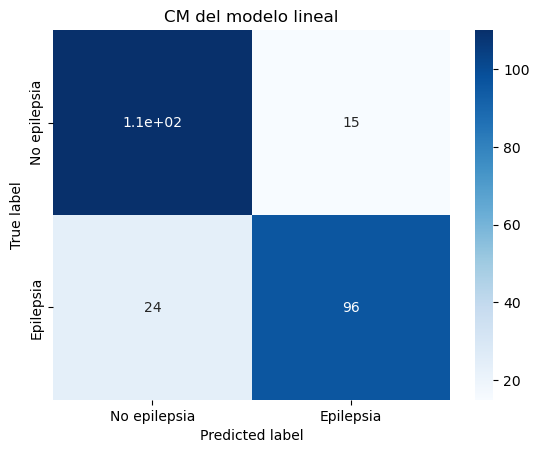

In [28]:
clasificaciones = ["No epilepsia","Epilepsia"]
predictions = modelo_leido_lineal.predict(test_x)
Accuracy = accuracy_score(test_y, predictions)
F1_score = f1_score(test_y, predictions)

print(f"{Accuracy=}" + '\n' + f"{F1_score=}" )

cm = confusion_matrix(test_y, predictions)
cm_df = pd.DataFrame(data=cm,index=clasificaciones,columns=clasificaciones)
ax = sns.heatmap(cm_df, cmap='Blues', annot=True)
ax.set_title('CM del modelo lineal')
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label");

Luego, leemos el modelo kernelizado con RBF

In [29]:
with open(r'pretrained_models/2-ch-gonza-rbf.pkl', 'rb') as file:
    modelo_leido_rbf = pickle.load(file)

Accuracy_RBF=0.5183673469387755
F1_score_RBF=0.078125


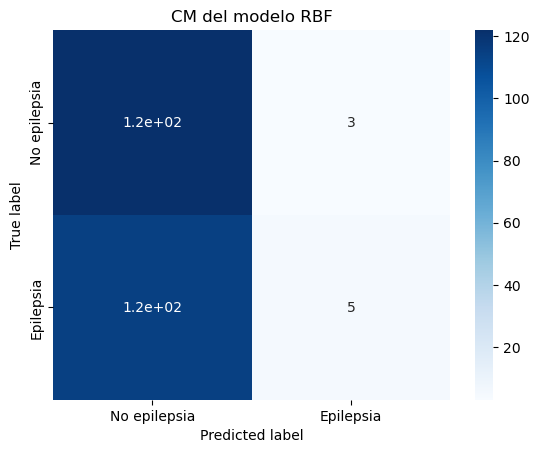

In [30]:
predictions_RBF = modelo_leido_rbf.predict(test_x)
Accuracy_RBF = accuracy_score(test_y, predictions_RBF)
F1_score_RBF = f1_score(test_y, predictions_RBF)

print(f"{Accuracy_RBF=}" + '\n' + f"{F1_score_RBF=}" )

cm_RBF = confusion_matrix(test_y, predictions_RBF)
cm_df = pd.DataFrame(data=cm_RBF,index=clasificaciones,columns=clasificaciones)
ax = sns.heatmap(cm_df, cmap='Blues', annot=True)
ax.set_title('CM del modelo RBF')
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label");

Este modelo resulta ineficiente a la hora de clasifica, con un alto número de falsos positivos y muy pocos verdaderos positivos

### Prueba del modelo con señales _online_

En la siguiente celda, clasificaremos segmentos sucesivos de las señales extraidas de los registros originales, emulando lo que se obtendría al aplicar el modelo a señales leídas en tiempo real. Se colorean de verde los segmentos clasificados como sin epilepsia, y en rojo aquellos en los que se detectó un ataque. Se encierra entre lineas verticales punteadas los verdaderos ataques, rotulados por los autores. Esto es posible mediante la función _online\_signal\_test_, del archivo _online\_signal\_test.py_

In [31]:
with open(r'pretrained_models/2-ch-gonza.pkl', 'rb') as file:
    modelo_leido = pickle.load(file)

Extracting EDF parameters from c:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN16\PN16-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



segmentando las señales de PN16-2.edf...
(233, 1024)
extrayendo las features de PN16-2.edf...
prediciendo en PN16-2.edf...
ploteando en PN16-2.edf...


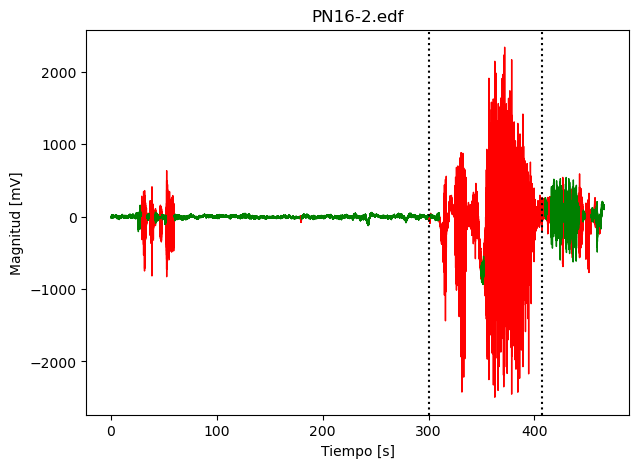

Extracting EDF parameters from c:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN16\PN16-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



segmentando las señales de PN16-1.edf...
(241, 1024)
extrayendo las features de PN16-1.edf...
prediciendo en PN16-1.edf...
ploteando en PN16-1.edf...


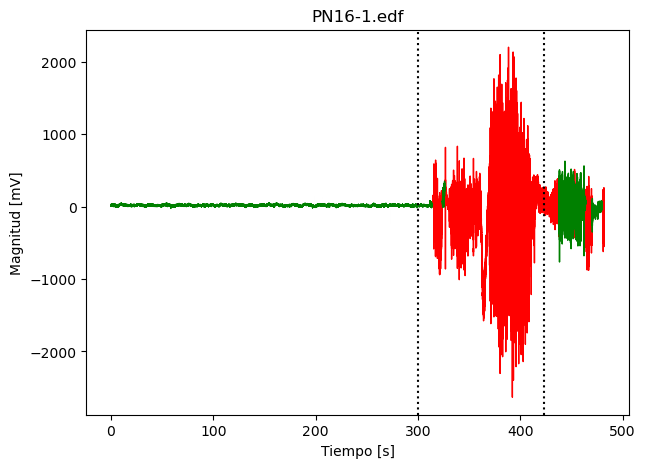

Extracting EDF parameters from c:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN13\PN13-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



segmentando las señales de PN13-3.edf...
(255, 1024)
extrayendo las features de PN13-3.edf...
prediciendo en PN13-3.edf...
ploteando en PN13-3.edf...


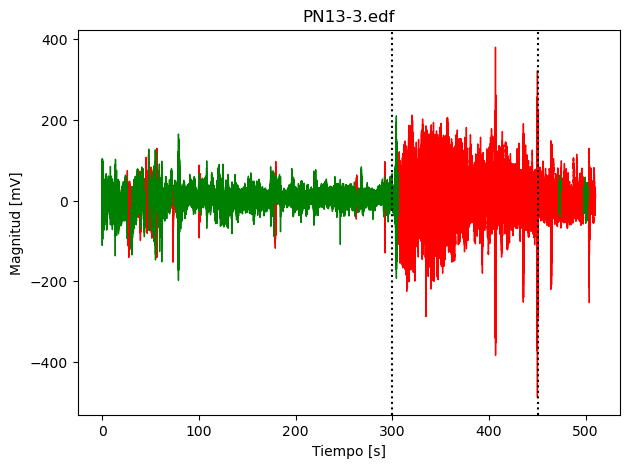

Extracting EDF parameters from c:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN12\PN12-1.2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



segmentando las señales de PN12-1.2.edf...
(211, 1024)
extrayendo las features de PN12-1.2.edf...
prediciendo en PN12-1.2.edf...
ploteando en PN12-1.2.edf...


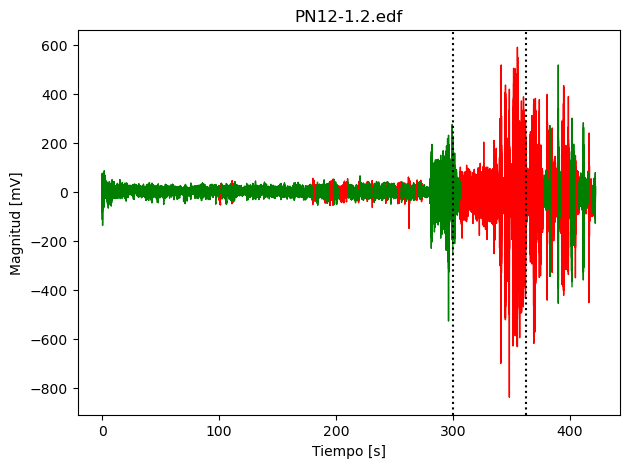

segmentando las señales de PN12-1.2.edf...
(214, 1024)
extrayendo las features de PN12-1.2.edf...
prediciendo en PN12-1.2.edf...
ploteando en PN12-1.2.edf...


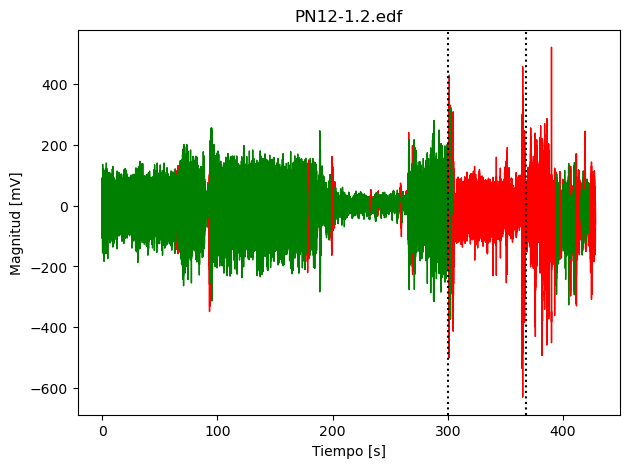

Extracting EDF parameters from c:\Users\gonza\Documents\ITBA\2024 1C\PSIB\TP FINAL PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN01\PN01-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



segmentando las señales de PN01-1.edf...
(207, 1024)
extrayendo las features de PN01-1.edf...
prediciendo en PN01-1.edf...
ploteando en PN01-1.edf...


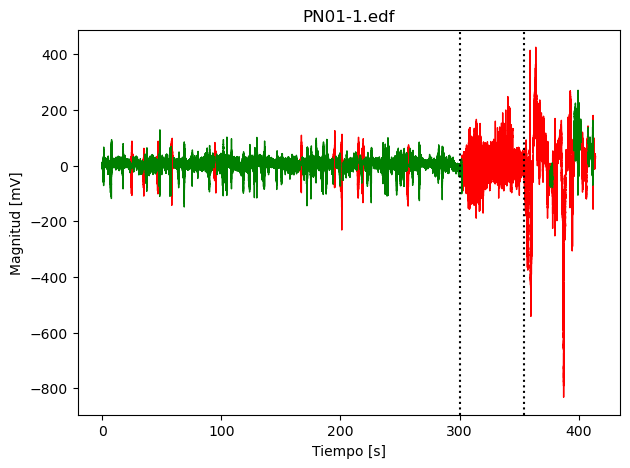

segmentando las señales de PN01-1.edf...
(217, 1024)
extrayendo las features de PN01-1.edf...
prediciendo en PN01-1.edf...
ploteando en PN01-1.edf...


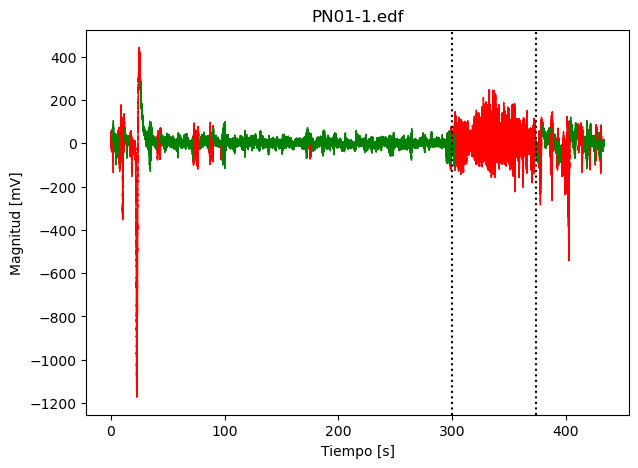

In [33]:
channels = ['EEG T3', 'EEG T5'] #, 'EEG F7', 'EEG F3', 'EEG C3', 'EEG P3']
indexes = []
labels = []
fs = None
edf_files = ['PN16/PN16-2.edf', 'PN16/PN16-1.edf', 'PN13/PN13-3.edf', 'PN12/PN12-1.2.edf', 'PN01/PN01-1.edf']


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for edf in edf_files:
        # Paso 1: duracion de señal y seizures
        name = edf.split('/')[-1]
        this_seizure_events = [seiz for seiz in seizure_events if seiz["file_name"]==name]
        
        if len(this_seizure_events) == 0:
            print('nada en', name)
            continue

        # Paso 2: extraemos la señal
        raw = io.read_raw_edf(rf"{DATASET_DIR}/{edf}")
        print('\n\n')
        if fs is None:
            fs = raw.info['sfreq']
        raw_filt = raw.pick(channels)
        data_namefilt = raw_filt.get_data() * 1e6

        # Ploteamos la clasificación aplicada "en tiempo real"
        for seiz in this_seizure_events:
            online_signal_test(modelo_leido, data_namefilt, channels, seiz, name, fs)

## Conclusión


anduvo. gracias.

## Bibliografía

1. Epilepsia - Síntomas y causas - Mayo Clinic. (2023, December 30). https://www.mayoclinic.org/es/diseases-conditions/epilepsy/symptoms-causes/syc-20350093

2. Types of Seizures. (n.d.). Epilepsy Foundation. https://epilepsyfoundation.org.au/understanding-epilepsy/seizures/types-of-seizures/

3. Epilepsia: MedlinePlus enciclopedia médica. (n.d.). https://medlineplus.gov/spanish/ency/article/000694.htm#:~:text=El%20tratamiento%20para%20la%20epilepsia,trastornos%20puede%20detener%20dichas%20crisis.

4. Electroencefalografía (EEG) - Mayo Clinic. (2022, July 19). https://www.mayoclinic.org/es/tests-procedures/eeg/about/pac-20393875

5. Sörnmo, L., & Laguna, P. (2005). Bioelectrical Signal Processing in Cardiac and Neurological Applications. Academic Press. http://books.google.ie/books?id=RQv7tFFXYyIC&printsec=frontcover&dq=978-0-12-437552-9&hl=&cd=2&source=gbs_api

6. Detti, P., Vatti, G., & De Lara, G. Z. M. (2020a, July 16). EEG Synchronization Analysis for Seizure Prediction: A Study on Data of Noninvasive Recordings. Processes. https://doi.org/10.3390/pr8070846